In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)


import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
from utils import save_data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
SEED=1234
n_splits=10

In [ ]:
def plot_scatter(oof,train_y):
    print('RMSE : ', np.sqrt(mean_squared_error(oof,train_y)))
    print('R^2 : ', r2_score(oof,train_y))
    plt.figure()
    plt.scatter(oof,train_y, alpha=0.7)
    plt.title("$R^2 = {:<.5}$".format(r2_score(oof,train_y)))
    x = np.linspace(0, 2500000, 100)
    plt.plot(x, x, c="indianred")
    plt.xlabel('predict', size=20)
    plt.ylabel('correct', size=20)

In [26]:
X_train=pd.read_csv('./psuedo/X_train1107.csv')
X_test=pd.read_csv('./psuedo/X_test1107.csv')

In [27]:
y_train=X_train['賃料']
y_test=pd.read_csv('./submit/1105_mean.csv',header=None)[1]
X_test['賃料']=y_test

In [29]:
folder=KFold(n_splits=10, shuffle=True, random_state=421)

In [67]:
folder2=KFold(n_splits=10, shuffle=True, random_state=422)

In [ ]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05

In [69]:
oof_df=pd.DataFrame()
oof_df['id']=pd.concat([X_train,X_test])['id']
oof_df=oof_df.reset_index(drop=True)
pred_df=pd.DataFrame()
pred_df['id']=X_test['id']
pred_df['pred']=0


for i,(train_idx, test_idx) in enumerate(folder2.split(X_test)):
    print(train_idx,test_idx)
    #これだとindexがおかしくなるので注意
    PX_train=pd.concat([X_train,X_test.iloc[train_idx,:]]).reset_index(drop=True)
    tr_idx=PX_train.index
    PX_test=X_test.iloc[test_idx,:]
    Py_train=PX_train['賃料']
    PX_train.drop(columns='賃料',inplace=True)
    PX_test.drop(columns='賃料',inplace=True)
    

    LogLGBM = LogRegressionPredictor(PX_train, Py_train.values, PX_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
    log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
    pred_df.loc[test_idx,'pred']=log_lgbpreds
    oof_df.loc[tr_idx,f'oof_{i}']=log_lgboof
    
    

[    1     2     3 ... 31259 31260 31261] [    0    23    26 ... 31191 31211 31232]
Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0181119	valid_1's l1: 0.0333296
[10000]	training's l1: 0.00965463	valid_1's l1: 0.0293982
[15000]	training's l1: 0.00602846	valid_1's l1: 0.0278824
[20000]	training's l1: 0.00410611	valid_1's l1: 0.027171
[25000]	training's l1: 0.00293766	valid_1's l1: 0.0268121
[30000]	training's l1: 0.00218408	valid_1's l1: 0.0266115
[35000]	training's l1: 0.00167488	valid_1's l1: 0.0264857
Early stopping, best iteration is:
[36109]	training's l1: 0.00158484	valid_1's l1: 0.0264683
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.017967	valid_1's l1: 0.0346102
[10000]	training's l1: 0.00962745	valid_1's l1: 0.0306506
[15000]	training's l1: 0.00598372	valid_1's l1: 0.0291221
[20000]	training's l1: 0.00406135	valid_1's l1: 0.0284638
[25000]	training's l1: 0.0029

In [112]:
pred_df=pred_df.set_index('id')

In [ ]:
oof_df['mean']=oof_df.drop(columns='id')[:X_train.shape[0]].mean(axis=1)

In [ ]:
pred_df.to_csv('./psuedo/1106_psuedo_pred.csv',header=None)
oof_df.to_csv('./psuedo/oof.csv')

In [125]:
save_data(X_train,oof_df[:X_train.shape[0]]['mean'].values,pred_df['pred'].values,rmse=11769,name='psuedo',save_dir='./stacking')

,id,target
0,31471,131646.856831
1,31472,118798.624635
2,31473,75368.629657
3,31474,60589.726860
4,31475,100999.047683


,id,target
0,1,80409.407413
1,2,70751.304590
2,3,107337.868528
3,4,167952.328934
4,5,68178.445861


RMSE :  11769.584699672801
R^2 :  0.9729055552928745


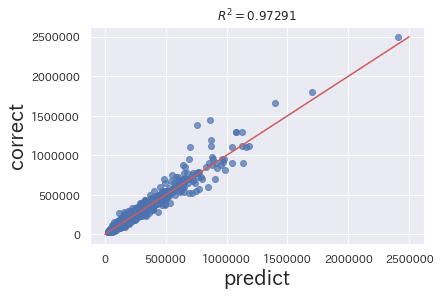

In [108]:
plot_scatter(oof_df['mean'][:X_train.shape[0]],y_train)

RMSE :  3625.2775530021454
R^2 :  0.9974091797194298


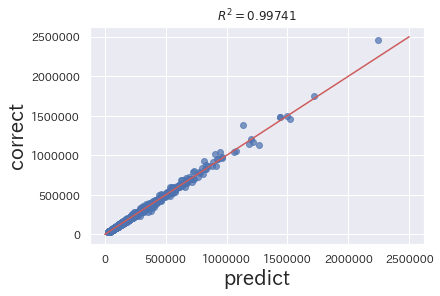

In [90]:
plot_scatter(pred_df['pred'],y_test)